In [1]:
#Imports
import pandas as pd
import numpy as np
from patsy import dmatrices
import statsmodels.api as sm
from statsmodels.stats.outliers_influence import variance_inflation_factor
from sklearn.linear_model import RandomizedLasso,LassoCV,LassoLarsIC
import seaborn as sns
import os

#Settin the working directory
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/MAG_Strava_Daily_counts")
#Function to calcualte Variance Inflation Factor
def vif_calculation(df):
    features = "+".join(df.columns)
    y, X = dmatrices('MAG_Daily ~' + features, df, return_type='dataframe')
    vif = pd.DataFrame()
    vif["VIF_Factor"] = [variance_inflation_factor(X.values, i) for i in range(X.shape[1])]
    vif["features"] = X.columns
    vif = vif.round(3)
    return vif

# Function to obtain variable selection using LASSO on the chosen variables with VIF
def lasso_var_select(df,VIF_features):
    X = df[VIF_features]
    Y = df["MAG_Daily"]
    names = X.columns
    y=0
    alpha,scores = [],[]
    model_bic = LassoLarsIC(criterion='bic')
    model_bic.fit(X, Y)
    alpha_bic_ = model_bic.alpha_
    low = alpha_bic_
    high = alpha_bic_+0.15
    for i in np.arange(low,high,0.005):
        y= y+1
        rlasso = RandomizedLasso(alpha=i)
        rlasso = rlasso.fit(X, Y)
        #print(names)
        alpha.append(i)
    rlasso = RandomizedLasso(alpha=np.mean(alpha))
    rlasso = rlasso.fit(X, Y)
    df=pd.DataFrame(sorted(zip(map(lambda x: round(x, 4), rlasso.scores_), 
                 names), reverse=True))
    df.columns = ["Rank","Variable"]
    df["alpha"] = np.mean(alpha)
    return df

In [4]:
train_data = pd.read_csv('Strava_MAG_counts_with_covariates.csv',index_col=None)
MAG_Daily = train_data[["MAG_Daily"]]
df1 = train_data[train_data.columns.difference(['MAG_Daily','ID','Site_ID',
                                                'Count_Day','Count_Season',
                                                'Sidewalk_factor','Bike_facility',
                                                'Connectivity_to_other_segments','Diff_pct'])]
vif_calculation(df1)

,VIF_Factor,features
0,586794.702,Intercept
1,4.700,AADT
2,1.597,Avg_segment_speed_limit
3,2.607,Count_Month
4,7.561,EDU_ABV_HS
5,12.931,EDU_BLW_HS
6,5.048,MEDIAN_AGE
7,8.060,MEDIAN_HOUSEHOLD_INCOME
8,2.360,PCT_BICYCLE
9,115.740,PCT_NON_WHITE


In [6]:
# Removing variables that logically seem correlated
df2 = df1[df1.columns.difference(['EDU_BLW_HS','PCT_WALKED','PCT_PUBLIC_TRANSPORTATION',
                                  'PCT_NON_WHITE','PCT_NO_VEHICLE'])]
vif_calculation(df2)

,VIF_Factor,features
0,353.330,Intercept
1,2.383,AADT
2,1.461,Avg_segment_speed_limit
3,2.495,Count_Month
4,2.339,EDU_ABV_HS
5,2.870,MEDIAN_AGE
6,6.832,MEDIAN_HOUSEHOLD_INCOME
7,1.541,PCT_BICYCLE
8,5.560,PCT_ONE_OR_MORE_VEH
9,2.694,PCT_VETERANS


Index([u'Rank', u'Variable', u'alpha'], dtype='object')
0.0738803375154


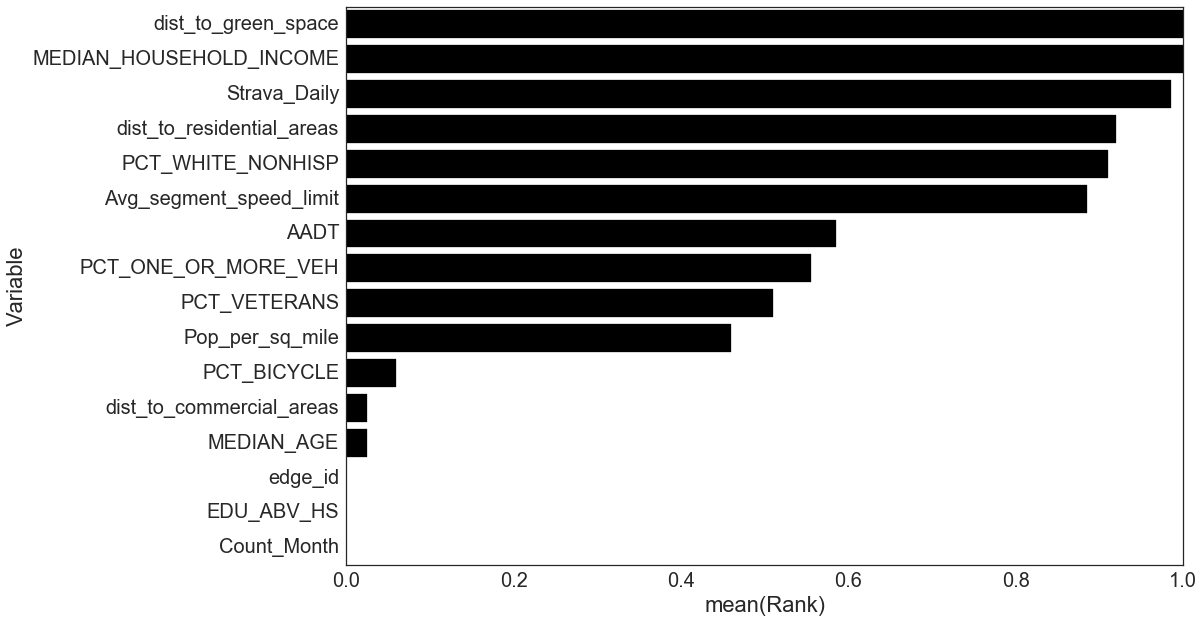

In [7]:
vif_results = vif_calculation(df2)
lasso_results = lasso_var_select(train_data,vif_results.features[1:].tolist())
print(lasso_results.columns)
xlab = lasso_results.columns[0]
ylab = lasso_results.columns[1]
print(np.mean(lasso_results.alpha))
sns.set(rc={'figure.figsize':(15,10)},font_scale=2,style='white')
sns.barplot(x=xlab,y=ylab,
            data=lasso_results,color="black").figure.savefig("LASSO_Output.png",dpi=300)

In [33]:
#Select variables with a rank above zero from LASSO output
lasso_vars = lasso_results.query("Rank>0.07")["Variable"].tolist()
lasso_vars.append('MAG_Daily')
lasso_vars.append('edge_id')
df_model_input = train_data[lasso_vars].groupby(['edge_id'],as_index=False).mean()
df_model_input["MAG_Daily"] = df_model_input.MAG_Daily.apply(lambda x: np.floor(x))
df_model_input.head()

,edge_id,dist_to_green_space,MEDIAN_HOUSEHOLD_INCOME,Strava_Daily,dist_to_residential_areas,Avg_segment_speed_limit,PCT_NON_WHITE,PCT_ONE_OR_MORE_VEH,AADT,Pop_per_sq_mile,PCT_VETERANS,PCT_BICYCLE,MAG_Daily
0,28482,0.2396,101131.0,9.230769,0.0291,60.0,3.194900,33.333300,6586.0000,390.2826,13.0186,0.000,78.0
1,91886,0.0000,65357.0,0.000000,0.0000,50.0,15.703050,33.333333,8979.0000,11881.6563,4.1068,0.000,59.0
2,117232,0.4039,96607.0,5.307692,0.0146,70.0,6.176475,33.333333,12418.5000,1261.8032,12.5227,0.000,47.0
3,126839,0.0000,40208.0,1.333333,0.0016,40.0,28.166800,29.933467,10039.0000,3219.7848,3.0093,0.000,49.0
4,129694,0.2040,41220.0,3.461538,0.0000,40.0,24.260350,27.554167,16900.6667,4564.1856,4.7967,5.994,55.0


In [6]:
#Write Outputs to Files
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/LASSO Results")
lasso_results.to_csv("LASSO_Output_April25_run2.csv")
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Input")
df_model_input.to_csv("GLM_Model_Input_April25_run2.csv")

In [6]:
#Function to run Generalized Linear Model on LASSO Features
require(glmnet)
require(boot)
glm_output <- function(train,test){
    predictors = train[,which(names(train)!="MAG_Daily")]
    #str(predictors)
    features = model.matrix(~.,predictors)
    newx = model.matrix(~.,test[,which(names(test)!="MAG_Daily")])
    target = matrix(train$MAG_Daily)
    cvfit <- cv.glmnet(y = target, x = features, family="poisson",nfolds = 100,alpha=1)
    cvlambda = cvfit$lambda
    cverror = cvfit$cvm
    plot(cvfit)
    lmin  <- cvfit$lambda.min
    l1se  <- cvfit$lambda.1se
    model.glmnet <- glmnet(y = target, x = features, family="poisson")
    #print(summary(model.glmnet))
    print(exp(coef(model.glmnet, s = lmin)))
    print(paste("Lambda for min Cross-validation error:", lmin))
    Predicted_Counts=predict(model.glmnet, newx, s=lmin, type = "response")
    return(Predicted_Counts)
}

#Function to calculate root mean squared error after k-fold cross-validation
options(warn=-1)
rmse_calc <- function(y,yhat) {return(sqrt(sum((y-yhat)^2)))}
model_error <- function(train_data){
    j=1
    score=c()
    train_size=c()
    rmse=c()
    test_size=c()
    set.seed(100)
    for (i in seq(0.15,0.95,0.0005))
        {
        sample = sample.int(n = nrow(train_data), size = floor(i*nrow(train_data)), replace = F)
        train_x = train_data[sample,-c(1,2,3,8,11)]
        test_x = train_data[-sample,-c(1,2,3,8,11)]
        true_Counts = train_data$MAG_Daily
        model = glm(MAG_Daily~.,data=train_x,family=poisson(link=log))
        cvfit = cv.glm(train_x,model,K=10)
        yhat = predict(model,test_x,type="response")
        #test$predicted = yhat
        score[j] = cvfit$delta[1]
        train_size[j] = i
        test_size[j] = 1-i
        rmse[j] = rmse_calc(test_x$MAG_Daily,yhat[1])
        j = j+1
        }
    errordf = data.frame(score,rmse,train_size,test_size)
    accuracy = function(x){1-(x/max(errordf$rmse))}
    errordf$rmse_pct = lapply(errordf$rmse,accuracy)
    return(errordf)
    }

In [2]:
library(boot)
setwd("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Input")
train_data = read.csv("GLM_Model_Input_April25_run2.csv")
str(train_data)

'data.frame':	338 obs. of  13 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  28482 91886 117232 126839 129694 129695 133980 375523 375524 379692 ...
 $ dist_to_green_space      : num  0.24 0 0.404 0 0.204 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  101131 65357 96607 40208 41220 ...
 $ Strava_Daily             : num  9.23 0 5.31 1.33 3.46 ...
 $ Avg_segment_speed_limit  : num  60 50 70 40 40 40 40 64 64 40 ...
 $ dist_to_residential_areas: num  0.0291 0 0.0146 0.0016 0 ...
 $ PCT_NON_WHITE            : num  3.19 15.7 6.18 28.17 24.26 ...
 $ PCT_ONE_OR_MORE_VEH      : num  33.3 33.3 33.3 29.9 27.6 ...
 $ AADT                     : num  6586 8979 12418 10039 16901 ...
 $ Pop_per_sq_mile          : num  390 11882 1262 3220 4564 ...
 $ PCT_VETERANS             : num  13.02 4.11 12.52 3.01 4.8 ...
 $ MAG_Daily                : num  78 59 47 49 55 55 55 55 56 18 ...


14 x 1 Matrix of class "dgeMatrix"
                                     1
(Intercept)               234.62281379
(Intercept)                 1.00000000
X                           0.99565564
edge_id                     1.00000179
dist_to_green_space         0.20210766
MEDIAN_HOUSEHOLD_INCOME     0.99997581
Strava_Daily                1.03548418
Avg_segment_speed_limit     0.99778490
dist_to_residential_areas   0.03316529
PCT_NON_WHITE               0.96789020
PCT_ONE_OR_MORE_VEH         1.01789794
AADT                        1.00001501
Pop_per_sq_mile             0.99995012
PCT_VETERANS                1.00715776
[1] "Lambda for min Cross-validation error: 0.0493067336800375"


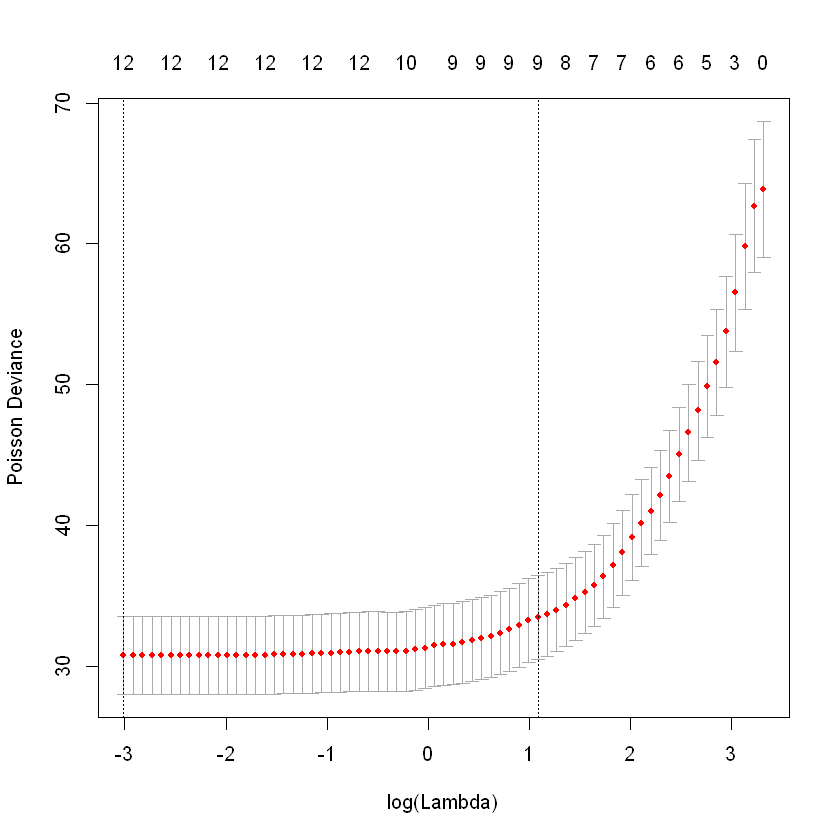

[1] "R-squared: 0.7695"

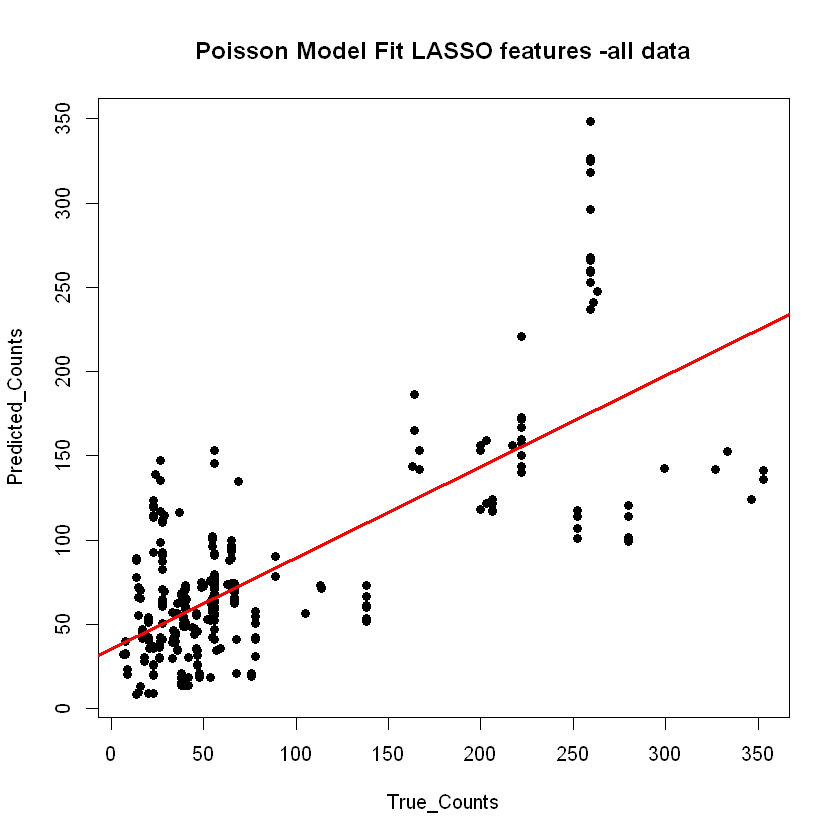

In [7]:
True_Counts = train_data$MAG_Daily
Predicted_Counts = glm_output(train_data,train_data)
#Predicted_Counts = rpois(length(Predicted_Counts1), lambda = Predicted_Counts1)
plot(True_Counts,Predicted_Counts,pch=16,main="Poisson Model Fit LASSO features -all data")
lmfit1 = lm(Predicted_Counts~True_Counts)
lmfit = lm(Predicted_Counts~True_Counts-1)
abline(lmfit1,col="red",lwd=3)
paste('R-squared:',round(summary(lmfit)$r.squared,4))   

In [15]:
#Use Tempe data for predictions
test_data = read.csv("TBAG_Strava_Counts_with_Covariates.csv")
test_data = test_data[,c("X","edge_id","dist_to_green_space",
                         "MEDIAN_HOUSEHOLD_INCOME","Strava_Daily",
                         "dist_to_residential_areas","Avg_segment_speed_limit",
                         "PCT_ONE_OR_MORE_VEH","PCT_NON_WHITE","AADT",
                         "Pop_per_sq_mile","PCT_VETERANS","MAG_Daily")]
str(test_data)

'data.frame':	47296 obs. of  13 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  381576 381576 381576 381576 381576 381576 381576 381576 381576 381576 ...
 $ dist_to_green_space      : num  0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : int  43889 43889 43889 43889 43889 43889 43889 43889 43889 43889 ...
 $ Strava_Daily             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ dist_to_residential_areas: num  0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 ...
 $ Avg_segment_speed_limit  : int  48 48 48 48 48 48 48 48 48 48 ...
 $ PCT_ONE_OR_MORE_VEH      : num  31.9 31.9 31.9 31.9 31.9 ...
 $ PCT_NON_WHITE            : num  4.13 4.13 4.13 4.13 4.13 ...
 $ AADT                     : int  33902 33902 33902 33902 33902 33902 33902 33902 33902 33902 ...
 $ Pop_per_sq_mile          : num  691 691 691 691 691 ...
 $ PCT_VETERANS             : num  3.37 3.37 3.37 3.37 3.37 ...
 $ MAG_Daily  

'data.frame':	47296 obs. of  12 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  381576 381576 381576 381576 381576 381576 381576 381576 381576 381576 ...
 $ dist_to_green_space      : num  0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 0.028 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : int  43889 43889 43889 43889 43889 43889 43889 43889 43889 43889 ...
 $ Strava_Daily             : int  1 1 1 1 1 1 1 1 1 1 ...
 $ dist_to_residential_areas: num  0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 0.402 ...
 $ Avg_segment_speed_limit  : int  48 48 48 48 48 48 48 48 48 48 ...
 $ PCT_ONE_OR_MORE_VEH      : num  31.9 31.9 31.9 31.9 31.9 ...
 $ PCT_NON_WHITE            : num  4.13 4.13 4.13 4.13 4.13 ...
 $ AADT                     : int  33902 33902 33902 33902 33902 33902 33902 33902 33902 33902 ...
 $ Pop_per_sq_mile          : num  691 691 691 691 691 ...
 $ PCT_VETERANS             : num  3.37 3.37 3.37 3.37 3.37 ...
14 x 1 Matrix 

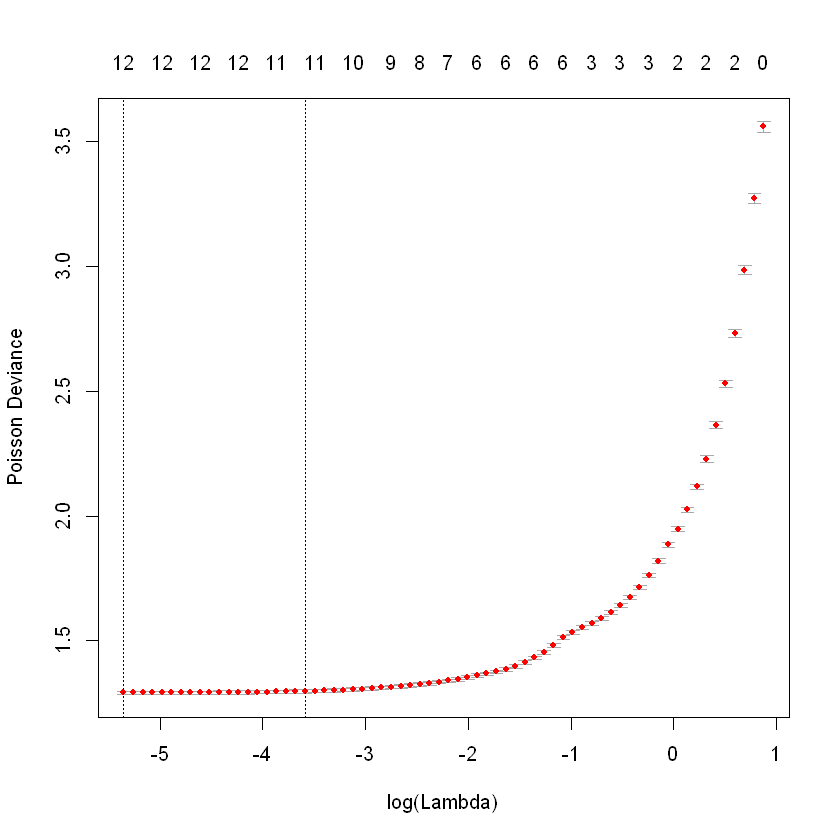

[1] "R-squared: 0.8064"

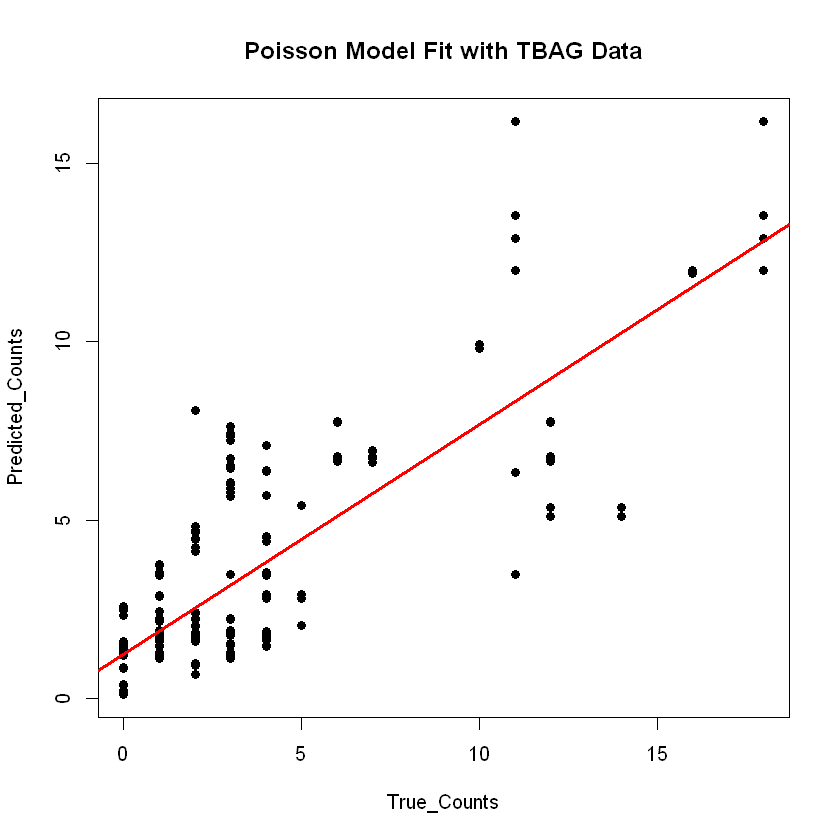

In [16]:
True_Counts = test_data$MAG_Daily
Predicted_Counts = glm_output(test_data,test_data)
#Predicted_Counts = rpois(length(Predicted_Counts), lambda = Predicted_Counts)
plot(True_Counts,Predicted_Counts,pch=16,main="Poisson Model Fit with TBAG Data")
lmfit1 = lm(Predicted_Counts~True_Counts)
lmfit = lm(Predicted_Counts~True_Counts-1)
abline(lmfit1,col="red",lwd=3)
paste('R-squared:',round(summary(lmfit)$r.squared,4))

In [6]:
mag_data = read.csv("GLM_Model_Input_April25_run2.csv")
mag_data = mag_data[,c("X","edge_id","dist_to_green_space","MEDIAN_HOUSEHOLD_INCOME",
                        "Strava_Daily","dist_to_residential_areas","Avg_segment_speed_limit",
                        "PCT_ONE_OR_MORE_VEH","PCT_NON_WHITE","AADT","Pop_per_sq_mile",
                        "PCT_VETERANS","MAG_Daily")]
str(mag_data)

'data.frame':	338 obs. of  13 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  28482 91886 117232 126839 129694 129695 133980 375523 375524 379692 ...
 $ dist_to_green_space      : num  0.24 0 0.404 0 0.204 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  101131 65357 96607 40208 41220 ...
 $ Strava_Daily             : num  9.23 0 5.31 1.33 3.46 ...
 $ dist_to_residential_areas: num  0.0291 0 0.0146 0.0016 0 ...
 $ Avg_segment_speed_limit  : num  60 50 70 40 40 40 40 64 64 40 ...
 $ PCT_ONE_OR_MORE_VEH      : num  33.3 33.3 33.3 29.9 27.6 ...
 $ PCT_NON_WHITE            : num  3.19 15.7 6.18 28.17 24.26 ...
 $ AADT                     : num  6586 8979 12418 10039 16901 ...
 $ Pop_per_sq_mile          : num  390 11882 1262 3220 4564 ...
 $ PCT_VETERANS             : num  13.02 4.11 12.52 3.01 4.8 ...
 $ MAG_Daily                : num  78 59 47 49 55 55 55 55 56 18 ...


In [7]:
#Predict Ridership volumes for all edges in Tempe
street_segments_Tempe = read.csv("Tempe_test_data_with_covariates.csv")
street_segments_Tempe = street_segments_Tempe[,c("X","edge_id","dist_to_green_space",
                                                 "MEDIAN_HOUSEHOLD_INCOME","Strava_Daily",
                                                 "dist_to_residential_areas","Avg_segment_speed_limit",
                                                "PCT_ONE_OR_MORE_VEH","PCT_NON_WHITE","AADT",
                                                 "Pop_per_sq_mile","PCT_VETERANS")]
str(street_segments_Tempe)

'data.frame':	37048 obs. of  12 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  48 48 50 51 51 51 51 52 52 53 ...
 $ dist_to_green_space      : num  0.00356 0.00356 0.00118 0.00532 0.00532 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  106979 106979 106979 41985 41985 ...
 $ Strava_Daily             : int  2 1 1 3 2 2 1 2 2 2 ...
 $ dist_to_residential_areas: num  0 0 0 0 0 0 0 0 0 0 ...
 $ Avg_segment_speed_limit  : int  75 75 75 0 0 0 0 75 75 0 ...
 $ PCT_ONE_OR_MORE_VEH      : num  32.9 32.9 32.9 27.8 27.8 ...
 $ PCT_NON_WHITE            : num  5.1 5.1 5.1 8.6 8.6 ...
 $ AADT                     : int  40902 40902 24541 8348 8348 8348 8348 9566 9566 0 ...
 $ Pop_per_sq_mile          : num  1873 1873 1873 1587 1587 ...
 $ PCT_VETERANS             : num  5.15 5.15 5.15 4.58 4.58 ...


'data.frame':	338 obs. of  12 variables:
 $ X                        : int  0 1 2 3 4 5 6 7 8 9 ...
 $ edge_id                  : int  28482 91886 117232 126839 129694 129695 133980 375523 375524 379692 ...
 $ dist_to_green_space      : num  0.24 0 0.404 0 0.204 ...
 $ MEDIAN_HOUSEHOLD_INCOME  : num  101131 65357 96607 40208 41220 ...
 $ Strava_Daily             : num  9.23 0 5.31 1.33 3.46 ...
 $ dist_to_residential_areas: num  0.0291 0 0.0146 0.0016 0 ...
 $ Avg_segment_speed_limit  : num  60 50 70 40 40 40 40 64 64 40 ...
 $ PCT_ONE_OR_MORE_VEH      : num  33.3 33.3 33.3 29.9 27.6 ...
 $ PCT_NON_WHITE            : num  3.19 15.7 6.18 28.17 24.26 ...
 $ AADT                     : num  6586 8979 12418 10039 16901 ...
 $ Pop_per_sq_mile          : num  390 11882 1262 3220 4564 ...
 $ PCT_VETERANS             : num  13.02 4.11 12.52 3.01 4.8 ...
14 x 1 Matrix of class "dgeMatrix"
                                     1
(Intercept)               234.61229516
(Intercept)                 1.

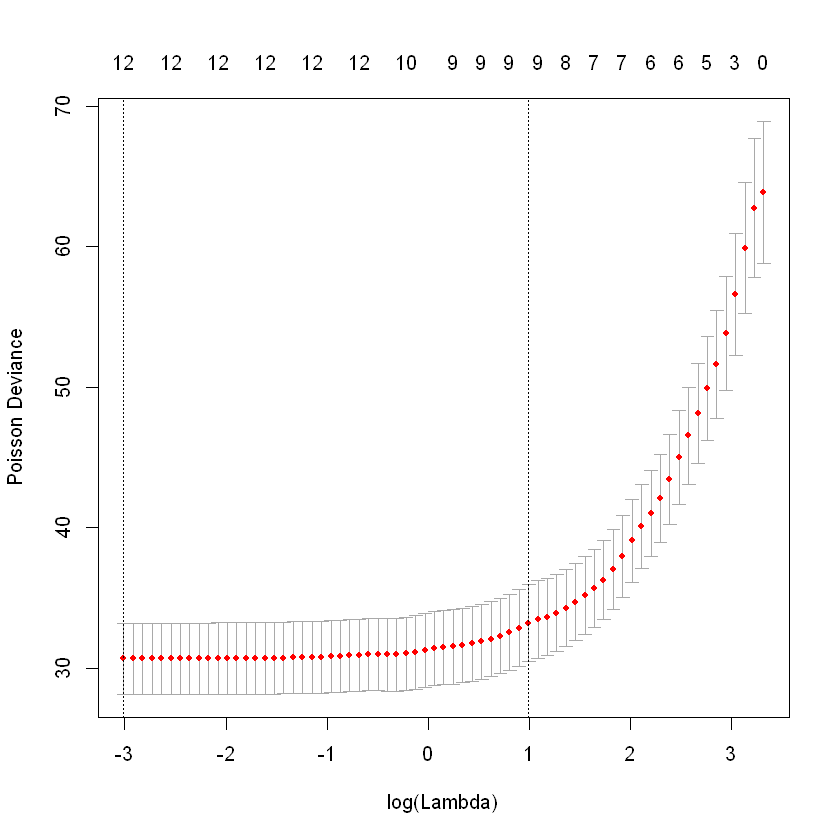

In [8]:
street_segments_Tempe$Predicted_Counts = glm_output(mag_data,street_segments_Tempe)

In [9]:
head(street_segments_Tempe[,c("edge_id","Strava_Daily","Predicted_Counts")])

edge_id,Strava_Daily,Predicted_Counts
48,2,42.19458
48,1,40.57160
50,1,31.72015
51,3,123.63670
51,2,118.88112
51,2,118.36465


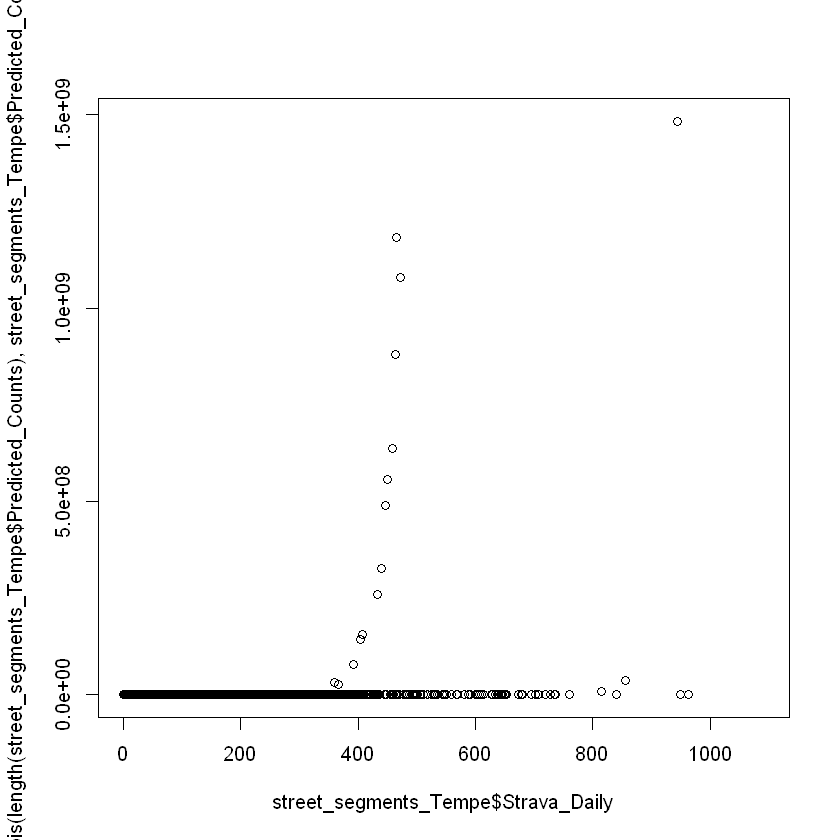

In [11]:
plot(street_segments_Tempe$Strava_Daily,rpois(length(street_segments_Tempe$Predicted_Counts),street_segments_Tempe$Predicted_Counts))

In [62]:
df = aggregate(Predicted_Counts~edge_id,street_segments_Tempe,mean)
df$"Predicted_Counts" = df$"1"
head(df)

edge_id,1,Predicted_Counts
48,0.4558809,0.4558809
50,0.3265642,0.3265642
51,4.0175646,4.0175646
52,4.6559592,4.6559592
53,3.7029978,3.7029978
54,4.6326633,4.6326633


In [63]:
setwd("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Output")
write.csv(df[,c('edge_id','Predicted_Counts')],"Predicted_Daily_Counts_Tempe_Apr23_run4.csv")

In [85]:
nrow(subset(df,Predicted_Counts<30000))

[1] 10405

In [19]:
errordf = model_error(train_data)
plot(errordf$test_size,errordf$rmse_pct,pch=16,
     xlab="Proportion of predicted segments",ylab="Error in Prediction",
    main="Variation of Model Prediction Accuracy with Amount of test data")
lines(loess.smooth(errordf$test_size,errordf$rmse_pct),col="red", lty=7, lwd=3)

SyntaxError: invalid syntax (<ipython-input-19-16d7b9604b16>, line 2)

In [5]:
#Classify Predicted Volumes based on no of segments in each category
import os
import numpy as np
import pandas as pd
import geopandas as gpd
os.chdir("C:/Users/aroy29/Dropbox (ASU)/Strava Analysis/Data/MAG2016/Analysis_Generated_Data/Model Output")
#Function to categorize predicted outcomes to classes
def assign_class(df,scenario):
    scale = []
    vol = df["Predicted_Counts"]
    if scenario==1:
        for item in vol:
            item = int(item)
            if(item in range(0,3)):
                scale.append('VL')
            elif(item in range(3,100)):
                scale.append('L')
            elif(item in range(100,800)):
                scale.append('M')
            elif(item in range(800,1500)):
                scale.append('H')
            else:
                scale.append('VH')
    elif scenario==2:
         for item in vol:
            item = int(item)
            if(item in range(0,10)):
                scale.append('VL')
            elif(item in range(10,200)):
                scale.append('L')
            elif(item in range(200,500)):
                scale.append('M')
            elif(item in range(500,2500)):
                scale.append('H')
            else:
                scale.append('VH')
    elif scenario==3:
         for item in vol:
            item = int(item)
            if(item in range(0,5)):
                scale.append('VL')
            elif(item in range(5,50)):
                scale.append('L')
            elif(item in range(50,150)):
                scale.append('M')
            elif(item in range(150,1400)):
                scale.append('H')
            else:
                scale.append('VH')
    elif scenario==4:
         for item in vol:
            item = int(item)
            if(item in range(0,100)):
                scale.append('VL')
            elif(item in range(100,400)):
                scale.append('L')
            elif(item in range(400,1200)):
                scale.append('M')
            elif(item in range(1200,2000)):
                scale.append('H')
            else:
                scale.append('VH')
    elif scenario==5:
        for item in vol:
            item = int(item)
            if(item in range(0,400)):
                scale.append('VL')
            elif(item in range(400,700)):
                scale.append('L')
            elif(item in range(700,1000)):
                scale.append('M')
            elif(item in range(1000,1700)):
                scale.append('H')
            else:
                scale.append('VH')
    else:
         for item in vol:
            item = int(item)
            if(item in range(0,5)):
                scale.append('VL')
            elif(item in range(5,125)):
                scale.append('L')
            elif(item in range(125,500)):
                scale.append('M')
            elif(item in range(500,1500)):
                scale.append('H')
            else:
                scale.append('VH')
    return scale

# Divide the TBAG data into train-test split and predict the classes using svm classifier
import itertools
import numpy as np
import matplotlib.pyplot as plt
from sklearn.multiclass import OneVsRestClassifier
from sklearn import svm, datasets
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix,precision_recall_curve,average_precision_score
from sklearn.ensemble import RandomForestClassifier

def generate_confusion_matrix(X_train,y_train,X_test,y_test):
    classifier = svm.LinearSVC(random_state=0)
    y_pred = classifier.fit(X_train, y_train).predict(X_test)
    # Compute confusion matrix
    cnf_matrix = confusion_matrix(y_test, y_pred)
    print(cnf_matrix)
    return cnf_matrix

def plot_confusion_matrix(cm, classes,normalize=False,title='Confusion matrix',cmap=plt.cm.Blues):
        """
        This function prints and plots the confusion matrix.
        Normalization can be applied by setting `normalize=True`.
        """
        plt.imshow(cm, interpolation='nearest', cmap=cmap)
        plt.title(title)
        plt.colorbar()
        tick_marks = np.arange(len(classes))
        plt.xticks(tick_marks, classes, rotation=45)
        plt.yticks(tick_marks, classes)

        fmt = '.2f' if normalize else 'd'
        thresh = cm.max() / 2.
        for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
            plt.text(j, i, format(cm[i, j], fmt),
                     horizontalalignment="center",
                     color="white" if cm[i, j] > thresh else "black")

        plt.tight_layout()
        plt.ylabel('True label')
        plt.xlabel('Predicted label')

In [25]:
#Read predicted outcome for tBAg data from file
tbag_predicted = pd.read_csv("Predicted_Daily_Counts_Tempe_Apr23_run4.csv")
tbag_predicted = tbag_predicted[tbag_predicted.columns.difference(["Unnamed: 0"])]
print(max(tbag_predicted.Predicted_Counts))
#Generating classes with 5 scenarios
tbag_predicted["scenario1"] = assign_class(tbag_predicted,1)
tbag_predicted["scenario2"] = assign_class(tbag_predicted,2)
tbag_predicted["scenario3"] = assign_class(tbag_predicted,3)
tbag_predicted["scenario4"] = assign_class(tbag_predicted,4)
tbag_predicted["scenario5"] = assign_class(tbag_predicted,5)
tbag_predicted["scenario6"] = assign_class(tbag_predicted,6)
tbag_predicted.head()

1.55988329328e+290


,Predicted_Counts,edge_id,scenario1,scenario2,scenario3,scenario4,scenario5,scenario6
0,0.455881,48,VL,VL,VL,VL,VL,VL
1,0.326564,50,VL,VL,VL,VL,VL,VL
2,4.017565,51,L,VL,VL,VL,VL,VL
3,4.655959,52,L,VL,VL,VL,VL,VL
4,3.702998,53,L,VL,VL,VL,VL,VL


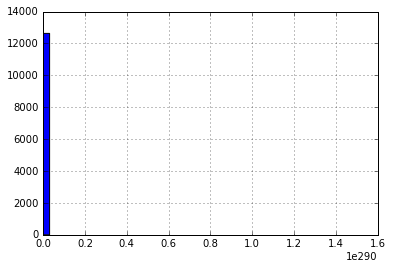

In [23]:
tbag_predicted["Predicted_Counts"].hist(bins=50)

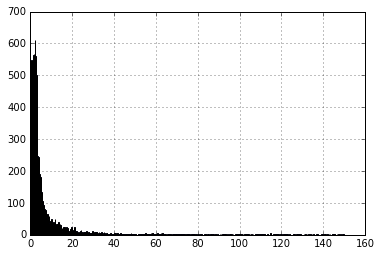

In [18]:
x = tbag_predicted.query("Predicted_Counts<150").Predicted_Counts
x.hist(bins=500)

In [ ]:
#Read the data and create a train-test split
X = np.array(tbag_predicted[["edge_id","Predicted_Counts"]])
y = np.array(y_scenario)

# Split the data into a training set and a test set
X_train, X_test, y_train, y_test = train_test_split(X, y,test_size=0.45, random_state=0)

#Create class labels
class_names = ["Very Low","Low","Medium","High","Very High"]

[[   0   40    0    0    0]
 [  29  609    0    0 1406]
 [   2  227    0    0    0]
 [   0   37    0 1167    0]
 [   0   19    0    0 2150]]


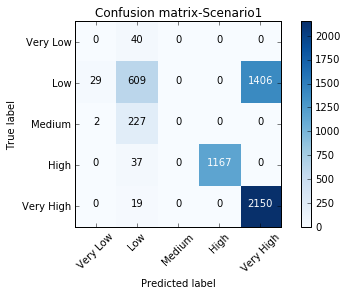

In [118]:
cnf1 = generate_confusion_matrix(tbag_predicted.scenario1,1)
# Plot non-normalized confusion matrix
plt.figure()
plot_confusion_matrix(cnf1, classes=class_names,title='Confusion matrix-Scenario1')
plt.show()

In [139]:
np.sum(cnf1.diagonal())

3926

In [140]:
np.sum(cnf1)

5686

In [88]:
tbag_predicted[["edge_id","scenario2"]].groupby(["scenario2"]).count()/len(tbag_predicted)

,edge_id
scenario2,
H,0.019946
L,0.154266
M,0.015197
VH,0.201757
VL,0.608833


[[   0    0    0   90   17]
 [   0  505    0    2  346]
 [   0    9    0   32   56]
 [   0    0    0 1177    0]
 [   0 2876    0    0  576]]


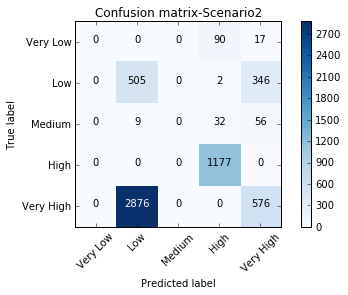

In [149]:
cnf2 = generate_confusion_matrix(tbag_predicted.scenario2,2)
plt.figure()
plot_confusion_matrix(cnf2, classes=class_names,title='Confusion matrix-Scenario2')
plt.show()

In [150]:
np.sum(cnf2.diagonal())

2258

In [144]:
np.sum(cnf2)

5686

In [90]:
tbag_predicted[["edge_id","scenario3"]].groupby(["scenario3"]).count()/len(tbag_predicted)

,edge_id
scenario3,
H,0.035618
L,0.215846
M,0.032452
VH,0.207852
VL,0.508232


[[ 203    0    0    4    0]
 [ 142   72    0  657  328]
 [  80   12    0   73    0]
 [1208    0    0    0    0]
 [   0    0  703  246 1958]]


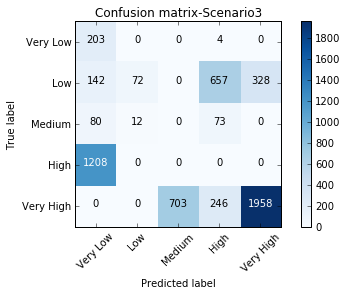

In [151]:
cnf3 = generate_confusion_matrix(tbag_predicted.scenario3,3)
plt.figure()
plot_confusion_matrix(cnf3, classes=class_names,title='Confusion matrix-Scenario3')
plt.show()

In [152]:
np.sum(cnf3.diagonal())

2233

In [92]:
tbag_predicted[["edge_id","scenario4"]].groupby(["scenario4"]).count()/len(tbag_predicted)

,edge_id
scenario4,
H,0.005541
L,0.030632
M,0.014880
VH,0.204290
VL,0.744657


[[   0    0    0   19    6]
 [   0    0    0    0  170]
 [   0    0    0    7   82]
 [   0    0    0 1179   10]
 [   0    0    0    0 4213]]


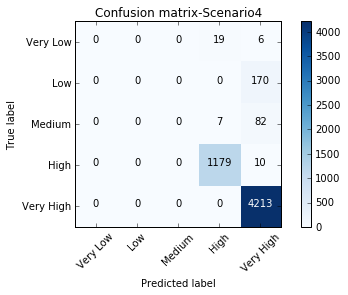

In [153]:
cnf4 = generate_confusion_matrix(tbag_predicted.scenario4,4)
plt.figure()
plot_confusion_matrix(cnf4, classes=class_names,title='Confusion matrix-Scenario4')
plt.show()

In [148]:
np.sum(cnf4.diagonal())

5392

In [94]:
tbag_predicted[["edge_id","scenario5"]].groupby(["scenario5"]).count()/len(tbag_predicted)

,edge_id
scenario5,
H,0.006490
L,0.007599
M,0.004670
VH,0.205952
VL,0.775289


[[   0    0   32    0    0]
 [   0    0   44    0    0]
 [   0    0   28    0    0]
 [   0    0 1199    0    0]
 [   0    0 4284    0   99]]


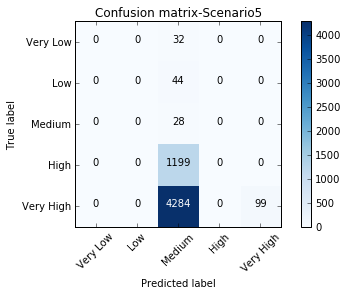

In [154]:
cnf5 = generate_confusion_matrix(tbag_predicted.scenario5,5)
plt.figure()
plot_confusion_matrix(cnf5, classes=class_names,title='Confusion matrix-Scenario5')
plt.show()

In [155]:
np.sum(cnf5.diagonal())

127

In [95]:
tbag_predicted[["edge_id","scenario6"]].groupby(["scenario6"]).count()/len(tbag_predicted)

,edge_id
scenario6,
H,0.014643
L,0.243391
M,0.026674
VH,0.207060
VL,0.508232


[[  80    0    0    0    0]
 [1336    1    0    0    2]
 [ 155    1    0    0    0]
 [1178    0    0   26    0]
 [2847    0    0    0   60]]


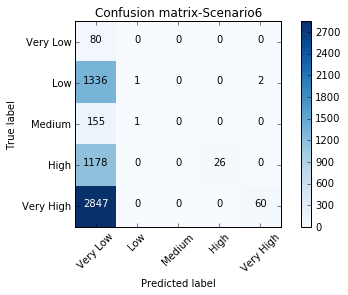

In [156]:
cnf6 = generate_confusion_matrix(tbag_predicted.scenario6,6)
plt.figure()
plot_confusion_matrix(cnf6, classes=class_names,title='Confusion matrix-Scenario6')
plt.show()

In [157]:
np.sum(cnf6.diagonal())

167